In [1]:
import numpy as np
import os
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from cp_detection.NeuralODE import GeneralModeDataset, LightningTrainer
from cp_detection.ForceSimulation import ForcedHarmonicOscillator,  SimulateGeneralMode
from cp_detection.InteractionForce import DMT_Maugis
import torch

## Define force model as well as QTF model to be used in simulating data

In [2]:
DMT = DMT_Maugis(0.2, 100, 2, 130, 1, 0.3, 0.3)
ode_params = {'Q':12000, 'A0':1, 'Om':1., 'k':1000}
FHO = ForcedHarmonicOscillator(**ode_params, force_model = DMT)
#FHO = ForcedHarmonicOscillator(**ode_params, force_model = Null)

## Simulate general mode approach curve data

In [3]:
d_array = np.linspace(1, 10, 90)
t, x_array = SimulateGeneralMode(FHO, d_array, 0.1, 10000, relaxation = 5, rtol = 1e-7)
x_array.shape

Data generation started
90/90 generated

(90, 2, 10000)

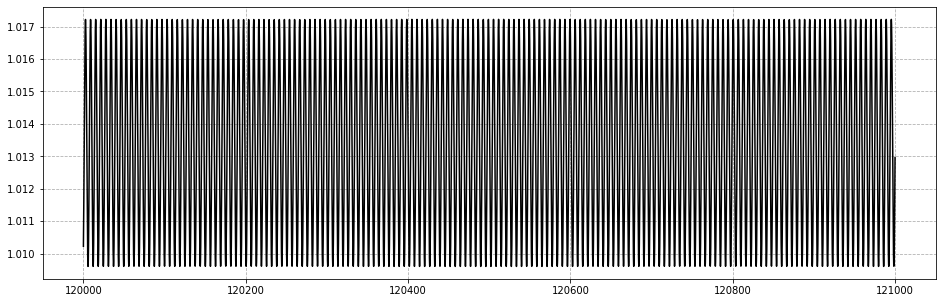

In [4]:
_, ax = plt.subplots(1, 1, figsize = (16, 5))
ax.plot(t[-10000:], x_array[0,1,:], 'k')
ax.grid(ls = '--')
#ax.axvline(x = 5*2*ode_params['Q'], color = 'b')
#ax.axvline(x = 10*2*ode_params['Q'], color = 'r')

In [5]:
import json
savepath = './Data/transient_original_90.json'
savedata = {'ode_params':ode_params, 'd_array': d_array.tolist(), 'x_array': x_array.tolist(), 't' : t.tolist()}
with open(savepath, 'w') as savefile:
    json.dump(savedata, savefile)

Saved data to: ./Data/digital_SNR=1000.json


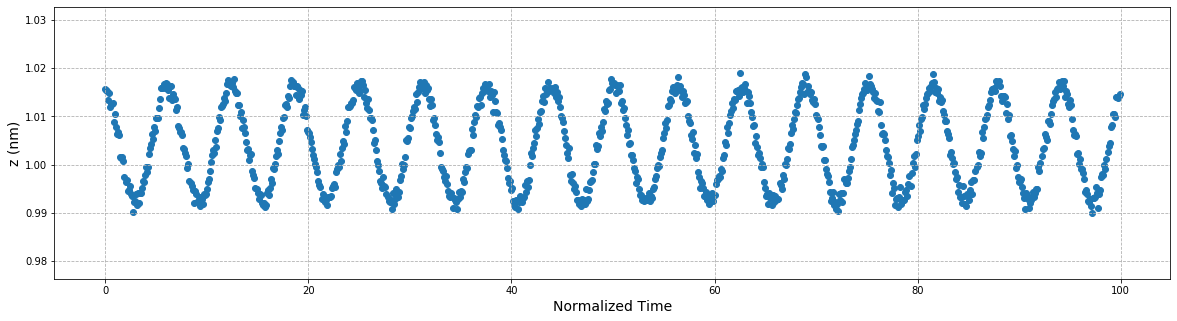

In [21]:
import json
loadpath = './Data/digital_original.json'
with open(loadpath) as loadfile:
    loaddata = json.load(loadfile)
train_dataset = GeneralModeDataset(**loaddata)
train_dataset.AddNoise(1000, 1337)
_, ax = plt.subplots(1, 1, figsize = (20, 5))
train_dataset.PlotData(0, ax, N_data = 5000)
#train_dataset.t = np.arange(1000)*0.1
#print(train_dataset.t)
#train_dataset.save('./Data/digital_fast.json')
train_dataset.save('./Data/digital_SNR=1000.json')

## Load simulated data and train the model

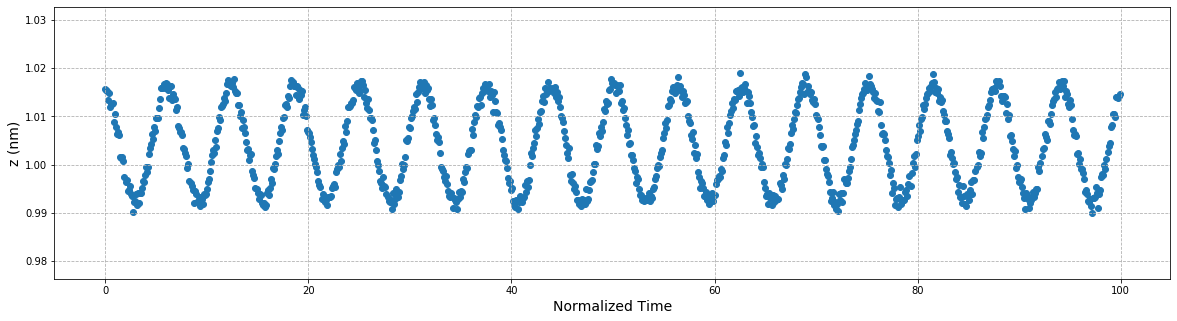

In [8]:
#savepath = './Data/digital.json'
#savepath = './Data/prototype_fake_data.json'
#savepath = './Data/digital_snr=1000.json'
savepath = './Data/digital_SNR=1000.json'
hidden_nodes = torch.Tensor([20, 20, 20, 20])
train_dataset = GeneralModeDataset.load(savepath)

_, ax = plt.subplots(1, 1, figsize = (20, 5))
train_dataset.PlotData(0, ax, N_data = 0)

In [9]:
if torch.cuda.is_available:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [16]:
from argparse import Namespace
#0.01->0.05
hparams = Namespace(**{'lr': 0.05, 'batch_size': 20, 'solver': 'rk4', 'train_dataset_path': savepath, 'hidden_nodes': hidden_nodes})
model = LightningTrainer(hparams)

In [17]:
for param in model.parameters():
    print(type(param.data), param.size())


<class 'torch.Tensor'> torch.Size([20])
<class 'torch.Tensor'> torch.Size([20, 1])
<class 'torch.Tensor'> torch.Size([20])
<class 'torch.Tensor'> torch.Size([20, 20])
<class 'torch.Tensor'> torch.Size([20])
<class 'torch.Tensor'> torch.Size([20, 20])
<class 'torch.Tensor'> torch.Size([20])
<class 'torch.Tensor'> torch.Size([20, 20])
<class 'torch.Tensor'> torch.Size([20])
<class 'torch.Tensor'> torch.Size([1, 20])
<class 'torch.Tensor'> torch.Size([1])


In [18]:
model.TrainModel(checkpoint_path = './checkpoints')

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
  | Name            | Type          | Params
----------------------------------------------
0 | ODE             | AFM_NeuralODE | 1 K   
1 | ODE.Fc          | F_cons        | 1 K   
2 | ODE.Fc.layers   | ModuleList    | 1 K   
3 | ODE.Fc.layers.0 | Linear        | 40    
4 | ODE.Fc.layers.1 | Linear        | 420   
5 | ODE.Fc.layers.2 | Linear        | 420   
6 | ODE.Fc.layers.3 | Linear        | 420   
7 | ODE.Fc.layers.4 | Linear        | 21    
8 | ODE.Fc.elu      | ELU           | 0     
9 | ODE.Fc.tanh     | Tanh          | 0     


INFO:lightning:
Epoch 00000: loss reached 0.04180 (best 0.04180), saving model to ./checkpoints/epoch=0_v3.ckpt as top 1
INFO:lightning:
Epoch 00001: loss reached 0.03404 (best 0.03404), saving model to ./checkpoints/epoch=1.ckpt as top 1
INFO:lightning:
Epoch 00002: loss reached 0.03378 (best 0.03378), saving model to ./checkpoints/epoch=2.ckpt as top 1
INFO:lightning:
Epoch 00003: loss reached 0.03376 (best 0.03376), saving model to ./checkpoints/epoch=3.ckpt as top 1
INFO:lightning:
Epoch 00004: loss reached 0.03376 (best 0.03376), saving model to ./checkpoints/epoch=4.ckpt as top 1
INFO:lightning:
Epoch 00005: loss  was not in top 1
INFO:lightning:
Epoch 00006: loss  was not in top 1
INFO:lightning:
Epoch 00007: loss  was not in top 1
INFO:lightning:
Epoch 00008: loss  was not in top 1
INFO:lightning:
Epoch 00009: loss  was not in top 1
INFO:lightning:
Epoch 00010: loss  was not in top 1
INFO:lightning:
Epoch 00011: loss  was not in top 1
INFO:lightning:
Epoch 00012: loss  was not 

## Load trained model, evaluate results

In [28]:
checkpoint_path1 = './checkpoints/epoch=2564.ckpt'
#checkpoint_path1 = './checkpoints/epoch=1197.ckpt'
#checkpoint_path2 = './checkpoints/epoch=714.ckpt'
#checkpoint_path = './hall_of_fame/20200206/_ckpt_epoch_319.ckpt'
model1 = LightningTrainer.LoadModel(checkpoint_path1)
#model2 = LightningTrainer.LoadModel(checkpoint_path2)

In [29]:
d_array = np.linspace(1, 10, 100)
model1.cuda()
F_pred1 = model1.predict_force(d_array).flatten()
#F_pred2 = model2.predict_force(d_array).flatten()
z_array = np.zeros((2, d_array.size))
z_array[1, :] = d_array
F_true = DMT(z_array).flatten()

Text(0, 0.5, 'Tip-Sample Force $F_{int}$ (nN)')

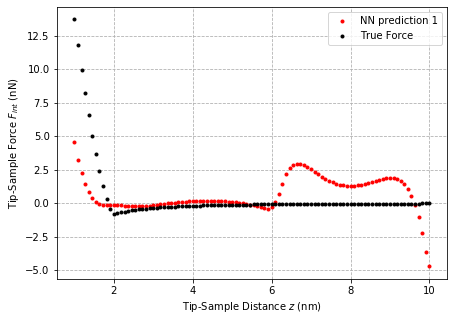

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.plot(d_array, F_pred1, '.r', label = 'NN prediction 1')
#ax.plot(d_array, F_pred2, '.b', label = 'NN prediction 2')
ax.plot(d_array, F_true, '.k', label = 'True Force')
ax.legend()
ax.grid(ls = '--')
ax.set_xlabel('Tip-Sample Distance $z$ (nm)')
ax.set_ylabel('Tip-Sample Force $F_{int}$ (nN)')
#ax.axvline(1, color = 'r')
#ax.axvline(10, color = 'r')

In [107]:
np.sqrt(np.mean((F_pred1 - F_true)**2)/np.mean(F_true**2))*100
#np.mean(F_true**2)

3.5413374938752384

In [36]:
(F_pred-F_true).shape

(100, 100)

In [15]:
model.train_dataset.d_array

array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
        3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
        5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
        8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ])

## Deprecated

In [12]:
from torchviz import make_dot, make_dot_from_trace

# Remember that you can use make_dot, make_dot_from_trace to get a nice visualization of the model flow
# But this does need one epoch of forward propagation, which is extremely costly in the steady state model
# The corresponding script to remember is:
# make_dot(loss, params=dict(nnode.named_parameters()))